## Installing and importing necessay Packages

In [78]:
!pip install tqdm

In [79]:
!pip install bert-for-tf2

In [80]:
!pip install sentencepiece

In [81]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

In [82]:
# if 'COLAB_TPU_ADDR' not in os.environ: 
#   print('Not connected to TPU') 
# else: 
#   print("Connected to TPU") 

## Getting Data


In [83]:
### Dataset too large for training
# train = pd.read_csv("Train.csv")
# train = pd.read_csv("Valid.csv")
# test = pd.read_csv("Test.csv")

### Taking only 
train = pd.read_csv("Test.csv")
test = pd.read_csv("Valid.csv")

In [84]:
# train = train.append(valid).reset_index(drop=True)

## Data visualisation

In [85]:
train.shape


(5000, 2)

In [86]:
train.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


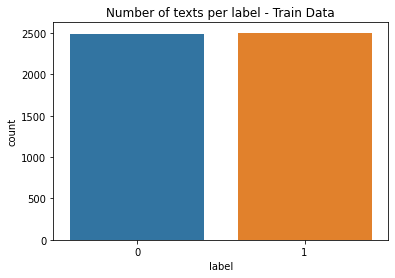

In [87]:
chart = sns.countplot(train.label)
plt.title("Number of texts per label - Train Data")
chart.set_xticklabels(chart.get_xticklabels());

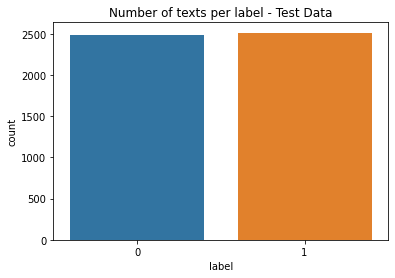

In [88]:
chart = sns.countplot(test.label)
plt.title("Number of texts per label - Test Data")
chart.set_xticklabels(chart.get_xticklabels());

## Getting Pre-trained BERT weights from Google

In [89]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-06-29 10:50:43--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M  56.2MB/s    in 11s     

2020-06-29 10:50:54 (36.3 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [90]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [91]:
os.makedirs("model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model

mv: cannot move 'uncased_L-12_H-768_A-12/' to 'model/uncased_L-12_H-768_A-12': Directory not empty


In [92]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Data Processing for Model

In [134]:
class ProcessData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "label"

    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=128):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
    
        for _, row in tqdm(df.iterrows()):
            text, label = row[ProcessData.DATA_COLUMN], row[ProcessData.LABEL_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [135]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [136]:
classes = train.label.unique().tolist()

data = ProcessData(train, test, tokenizer, classes, max_seq_len=128)

5000it [00:17, 288.92it/s]
5000it [00:17, 291.94it/s]


max seq_len 3035


In [137]:
data.train_x.shape

(5000, 128)

In [138]:
data.train_x[0]

array([  101,  1045,  2467,  2626,  2023,  2186,  2125,  2004,  2108,
        1037,  3143, 27136,  1011, 17037,  2138,  3958, 19337, 20668,
        2072,  2001,  2920,  1999,  2009,  1010,  1998,  4600,  1012,
        2021,  2059,  2028,  2154,  1037, 13800,  6433, 26897,  4158,
        1012,  2044,  1037,  2317,  9175,  2208,  3092,  1045,  3651,
        2008,  1996,  6556,  2001,  2035,  1996,  2126,  2006,  1996,
        2060,  2217,  1997,  1996,  2282,  5064,  1012,  2085,  1045,
        2071,  2031,  2074,  5407,  2039,  1998,  2939,  2408,  1996,
        2282,  2000,  2131,  1996,  6556,  1010,  2030,  2130,  2000,
        1996,  2694,  2000,  2735,  1996,  3149,  1012,  2021,  2059,
        2339,  2025,  2074,  2131,  2039,  1998,  3328,  2408,  1996,
        2406,  2000,  3422,  2694,  1999,  2178,  2110,  1029,  1000,
       12264,  2000,  2008,  1000,  1010,  1045,  2056,  1012,  2061,
        1045,  2787,  2000,  2074,  6865,  4389,  2006,  1996,  6411,
           0,     0]

In [139]:
data.train_y[0]

0

In [140]:
data.max_seq_len

128

## Model Creation

In [141]:
def create_model(max_seq_len, bert_ckpt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")

    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)

    return model

In [142]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd3532df4a8> (prefix:bert_7). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [143]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda_5 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 768)               590592    
_________________________________________________________________
dropout_11 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 1538

In [144]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)


## Creating checkpoints and training Model

In [145]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# model.load_weights(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [148]:
# log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)


# Create a callback that saves the model's weights


history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=10,
  callbacks=[cp_callback]
)
model.save_weights('./training/cp.ckpt')

Epoch 1/10
282/282 [==============================] - ETA: 0s - loss: 0.5429 - acc: 0.7522
Epoch 00001: saving model to training/cp.ckpt
282/282 [==============================] - 228s 807ms/step - loss: 0.5429 - acc: 0.7522 - val_loss: 0.4752 - val_acc: 0.8280
Epoch 2/10
282/282 [==============================] - ETA: 0s - loss: 0.4683 - acc: 0.8371
Epoch 00002: saving model to training/cp.ckpt
282/282 [==============================] - 226s 800ms/step - loss: 0.4683 - acc: 0.8371 - val_loss: 0.4817 - val_acc: 0.8240
Epoch 3/10
282/282 [==============================] - ETA: 0s - loss: 0.4270 - acc: 0.8851
Epoch 00003: saving model to training/cp.ckpt
282/282 [==============================] - 225s 799ms/step - loss: 0.4270 - acc: 0.8851 - val_loss: 0.4584 - val_acc: 0.8480
Epoch 4/10
282/282 [==============================] - ETA: 0s - loss: 0.4068 - acc: 0.9044
Epoch 00004: saving model to training/cp.ckpt
282/282 [==============================] - 225s 799ms/step - loss: 0.4068 - a

## Load model from Saved weights

In [149]:
# model = create_model(data.max_seq_len, bert_ckpt_file)
# model.compile(
#   optimizer=keras.optimizers.Adam(1e-5),
#   loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
# )

# model.load_weights('./training/cp.ckpt')

## Analyzing Results

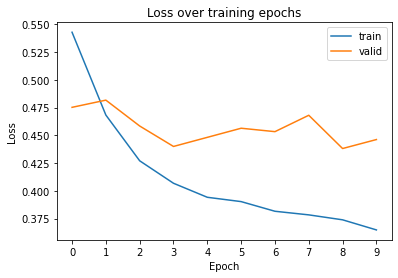

In [150]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.title('Loss over training epochs')
plt.show()

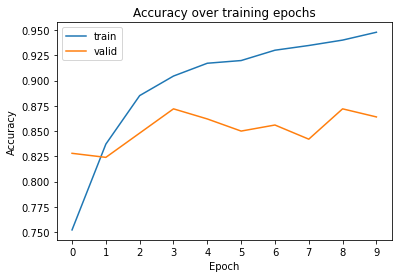

In [151]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'])
plt.title('Accuracy over training epochs')
plt.show();

## Prediction on Test data

In [152]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("Train acc", train_acc)
print("Test acc", test_acc)

157/157 [==============================] - 56s 359ms/step - loss: 0.4637 - acc: 0.8474
Train acc 0.9490000009536743
Test acc 0.8474000096321106


In [153]:
y_pred = model.predict(data.test_x).argmax(axis=-1)
# y_pred

In [154]:
# data.test_y

In [155]:
print(classification_report(data.test_y, y_pred, target_names=['neg', 'pos']))

              precision    recall  f1-score   support

         neg       0.82      0.89      0.85      2486
         pos       0.88      0.80      0.84      2514

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [156]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

Text(0.5, 15.0, 'Predicted label')

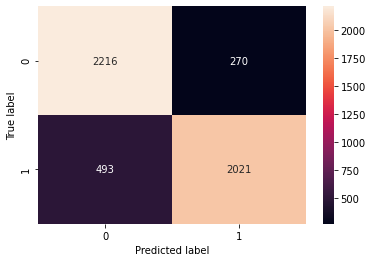

In [157]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels())
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Prediction on some self-created Movie reviews

In [159]:
sentences = [
  "While Followed won’t lead you to any conclusions that you can’t get reach by yourself, it’s sometimes fun getting there anyway.",
  "An astonishingly beautiful coming-of-age story of startling specificity and intense intimacy, yet universal in its compassionate depiction of a child's perspective dawning on mature self-awareness.",
  "There is not a moment of dialogue that feels spontaneous or genuine.",
  "Once Yummy kicks off its apocalypse by introducing this patient zero, that’s when things start to get really bad.",
  "The film might be set in another time and deals with hatred of a specific kind, it feels prescient for the here and the now because hate hasn’t quite died amongst us",
  "On the whole Race 3 is not entirely unentertaining but it is majorly disappointing.",
  "I saw it in 2007 for the first time and since then it is undoubtedly one of my favorite movie.",
  "It does get preachy and you find yourself shifting in your seats a lot towards the final scene, but the movie wins you over with its innocence and simplicity.",
  "",
  "Lots of hype and expectations proving to be just a sham",
  "Delivers as expected from the studio that brought you Star Trek.",
  "No words to express",
  " Absolutely awesome!!"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

target_class = ['negative', 'positive']
for text, label in zip(sentences, predictions):
    print("text:", text, "\nlabel:", target_class[label])
    print()

text: While Followed won’t lead you to any conclusions that you can’t get reach by yourself, it’s sometimes fun getting there anyway. 
label: positive

text: An astonishingly beautiful coming-of-age story of startling specificity and intense intimacy, yet universal in its compassionate depiction of a child's perspective dawning on mature self-awareness. 
label: positive

text: There is not a moment of dialogue that feels spontaneous or genuine. 
label: negative

text: Once Yummy kicks off its apocalypse by introducing this patient zero, that’s when things start to get really bad. 
label: negative

text: The film might be set in another time and deals with hatred of a specific kind, it feels prescient for the here and the now because hate hasn’t quite died amongst us 
label: positive

text: On the whole Race 3 is not entirely unentertaining but it is majorly disappointing. 
label: negative

text: I saw it in 2007 for the first time and since then it is undoubtedly one of my favorite mov